# BigPatent Dataset: Data Wrangling and Exploratory Data Analysis

In this notebook we shall go through the data wrangling and data exploration process for the BigPatent dataset. 

As a refresher, the BigPatent dataset is a corpus consisting of all the patents filed with he USPTO since since the 1970s. It is used for training text summarization models. 

The dataset is grouped into 9 different patent categories using different cpc codes. Where the code definition is as follows:  
* a is for 'HUMAN NECESSITIES'
* b is for 'PERFORMING OPERATIONS & TRANSPORTING'
* c is for 'CHEMISTRY & METALLURGY' 
* d is for 'TEXTILES & PAPER'
* e is for 'FIXED CONSTRUCTIONS'
* f is for 'MECHANICAL ENGINEERING, LIGHTING, HEATING,WEAPONS, & BLASTING'
* g is for 'PHYSICS'
* h is for 'ELECTRICITY'
* y is for 'GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS'

More details on the dataset can be found at https://arxiv.org/pdf/1906.03741.pdf

## Notebook Outline:  
1. Data collection    
2. Read-in the raw data as a Pandas dataframe
3. Text cleaning/normalization  
4. Generate a vocabulary of all the different words used in the corpus  
5.  Do exploratory analysis on the vocabulary to better understand the corpus  
6. Analyze the distribution of lengths of the description and abstract texts in the corpus for different cpc codes  
7. Generate word2idx and idx2word dictionaries 
8. Save the pre-processed data in raw string and Numpy array formats for future model training

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [27]:
import sys
import os
import time
import numpy as np
import pandas as pd
import json
import gzip
import re
import spacy
import matplotlib.pyplot as plt
%matplotlib inline


#To ensure that the Colab Python interpreter can load Python files from within
FOLDER_NAME = os.path.join('/', 'content', 'gdrive', 'My Drive', 'Colab Notebooks', 'UCSDX_MLE_Bootcamp', 'Capstone_Project', 'Step5_12-5-1_DataWrangling')
sys.path.append(FOLDER_NAME)
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My Drive/Colab Notebooks/UCSDX_MLE_Bootcamp/Capstone_Project/Step5_12-5-1_DataWrangling', '/content/gdrive/My Drive/Colab Notebooks/UCSDX_MLE_Bootcamp/Capstone_Project/Step5_12-5-1_DataWrangling']


In [28]:
os.chdir(FOLDER_NAME)
!pwd

/content/gdrive/My Drive/Colab Notebooks/UCSDX_MLE_Bootcamp/Capstone_Project/Step5_12-5-1_DataWrangling


## Data Collection

Get this script from 'data_collection_step_3-5-2' from https://github.com/amitp-ai/Text_Summarization_UCSD/tree/main/Data_Collection_3-5-2

In [ ]:
# !python Data_Collection_Script.py
# !ls
# !du -sh ./bigPatentData

## Reading-in the Data

In [ ]:
def readDataFile(input_path,split_type,cpc_code):
    '''
    input_path <string>: path to the data directory
    split_type <string>: train or val or test
    cpc_code <string>: can be either of abcdefghy
    '''
    file_names = os.listdir(os.path.join(input_path,split_type,cpc_code))
    # print(file_names)
    for file_name in file_names:
        # file_name = file_names[0] # reading one of the gz files.
        yield os.path.join(input_path,split_type,cpc_code,file_name)


def readDataExample(input_path,split_type,cpc_code):
    '''
    code adapted from 'https://evasharma.github.io/bigpatent/' with some modifications
    '''
    for fname in readDataFile(input_path,split_type,cpc_code):
        with gzip.open(fname,'r') as fileh:
            for row in fileh:
                json_obj = json.loads(row)
                # print("Fields present in each of the json object:")
                # print(json_obj.keys())
                
                # #uncomment to print the publication number, abstract and description
                # print(json_obj["publication_number"])
                # print(json_obj["abstract"])
                # print(json_obj["description"])
                yield json_obj


def readData_into_PandasDF(input_path, split_type, cpc_code, max_df_size = 40000):
    #Each pd dataframe is a chunck of ~40k examples
    df_list, num_examples = [], 0
    for file_name in readDataFile(input_path, split_type, cpc_code):
        df = pd.read_json(file_name, lines=True, compression='gzip')
        df['source_filename'] = file_name
        # print(len(df), df.shape, '\n', df.columns, '\n', df.head())
        df_list.append(df)
        num_examples += df.shape[0]
        if num_examples > max_df_size:
            df = pd.concat(df_list)
            # print(df.shape, '\n', df.columns, '\n', df.head())
            df_list, num_examples = [], 0
            yield df
    if df_list != []:
        df = pd.concat(df_list)
        # print(df.shape, '\n', df.columns, '\n', df.head())
        yield df



split_type = 'train' #can be train, test, val
cpc_code = 'd' #can be a,b,c,d,e,f,g,h,y
input_path = './bigPatentData'
# print(len(list(readDataExample(input_path,split_type,cpc_code))))

for df in readData_into_PandasDF(input_path, split_type, cpc_code):
    print(df.shape)

(10164, 5)


## Data Cleaning/Pre-Processing

The data cleaning process is as follows:-
1. Lower-case all the words. This is done by default in the dataset. But we will still do it as part of our pipeline so that we can use later for inference.

2. Replace all numbers with a single token named 'NUMBER#'. Because there are so many different types of numbers, this way we can manage the complexity without completely discarding numbers. Moreover later on, for character level tokenization, we will use numbers, i.e. included numbers in character vocabulary.

3. Remove tokens that look like punctuations but aren;t really e.g. //, ./, )/, etc. But we will keep true punctuations (.,;:'\/?!+=-*&^%$#) inorder for the model to better "understand" the underlying text that we will be summarizing.


4. Remove acccent words and words with special unicode characters


5. Fix abbreviations that aren't properly tokenized e.g. 'i', '.', 'e', '.' => 'i.e.'

6. Remove words with long underscores for figures e.g. '_______________________'


7. Remove stop words. These are words that add little meaning to the sentence, but are very commonly used e.g. a, then, an, etc. But we will keep these as it helps model to generate better text summaries.

Things to try in the future:-  
1. Lemmatization/stemming  
    e.g. driving, drive, dirves => drive

2. Contraction expansion  
    e.g. I'd => I would  
    (No need to do this as we have a lot of data so want the model to learn to produce contractions in the output to better match the abstract.) Moreover, I verified for cpc d and e that there are no contractions in the training set.

3. Spelling Correction

### A note on word tokenization:
The raw data is already in lower case and has punctuations spaced out from words e.g. **'This is book.'** is like **'This is book .'** So string.split(' ') works pretty well for tokenization for the most part. 

From my experimentations, there a few instances where spacy and nltk's word tokenizer gives different results, it appears as if the raw data is pre-processed to be used with a str.split(' ') as the preferred means of word tokenzation. It seems to be giving the best results. So that is what we will use; and as a side benefit, it is significantly faster than spacy or nltk.


In [ ]:
import unicodedata

nlp = spacy.blank("en") #spacy is faster than nltk for word_tokenizing at least
replacement_string = '--oov--'
def get_abbreviations(text_list):
    '''
    e.g. 'i',' ','.', 'e', ' ', '.' => 'i.e.'
    There are even numbers like 1 . 3 => 1.3 then convert it to #number#
    Wasn't 100% successful with Regex... Hence this Python function
    The raw data has abbreviations broken into separate tokens. This function will combine them properly.
    Input (text_list): list of string
    output (text_list): list of string
    '''
    alphabets = set(c for c in 'abcdefghijklmnopqrstuvwxyz') #make it a set for fast access
    i = 0
    while i+1 < len(text_list):
        k = 0
        while i+k+1 < len(text_list) and text_list[i+k] in alphabets and text_list[i+k+1] == '.':
            k += 2
        k -= 2
        if k > 0:
            text_list[i] = ''.join(text_list[i:i+k+2])
            text_list[i+1:i+k+2] = ['']*(k+1)
            i += (k+1)+1 #note this means i will really be (k+1)+2 as there is i+=1 below
        i += 1
    text_list = [t for t in text_list if t != '']
    return text_list


def remove_tokens_with_letters_and_numbers(text_list):
    '''
    E.g. 'this1234'
    The below regex does this but it doesn't work 100% of the time and it is slower. Hence this Python function.
        #to get rid of tokens with numbers and letters in it
        myRegEx3 = re.compile(r'((\d+[a-z]+\d+)|([a-z]+\d+[a-z]+)|([a-z]+\d+)|(\d+[a-z]+))')
        text = myRegEx3.sub(replacement_string, text)
    '''
    for i in range(len(text_list)):
        t = text_list[i]
        if any(c.isdigit() for c in t) and any(c.isalpha() for c in t):
            text_list[i] = replacement_string
    return text_list


def Clean_Text_Post_Tokenization(text_list):
    text_list = remove_tokens_with_letters_and_numbers(text_list)
    text_list = get_abbreviations(text_list)
    return text_list


def Word_Tokenize(text):
    '''
    Descr: Tokenize the input text
    Input: text is raw string and nlp is spacy object for word tokenization
    Output: List of str
    '''
    #Directly tokenize into words. No need for sentence tokenization first.
    # text = nlp(text) #no need to use this (its also much slower)
    # text = [t.text for t in text]
    # text = text.split(' ') #use string split() as the raw data is setup for it vs spacy/nltk's word tokenizer (as discussed above)
    text = text.split(' ') #use string split() as the raw data is setup for it vs spacy/nltk's word tokenizer (as discussed above)
    return text


def remove_accented_chars(text):
    #remove characters like 'Sómě Áccěntěd těxt'
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def Clean_Text(text):
    #convert to raw string
    text = text.encode('unicode-escape').decode()

    # #get rid of parenthesis (no don't do this! Keep parenthesis)
    # myRegEx0 = re.compile(r'[\[\(] (\w+) [\]\)]')
    # text = myRegEx0.sub(r'\1', text)

    # address cases where there is no space between punctuations e.g. ').' => ')' '.'
    myRegEx0 = re.compile(r'([\.\,\:\;])?([\]\)\}\>])([\.\,\:\;])') 
    text = myRegEx0.sub(r'\1 \2 \3', text)

    #to get rid of tokens with multiples of punctuations e.g. '&#;' (**do this second**)
    myRegEx1 = re.compile(r'[\&\,\;\:\\\/\?\!\+\=\%\$\#\.\(\)\{\}\[\]\-\*\@\^\|\~]{2,}')
    text = myRegEx1.sub(replacement_string, text)


    #to get rid of very long underscores e.g. 'Fig1____________________Results'
    myRegEx2 = re.compile(r'\S*_(_)+_\S*')
    text = myRegEx2.sub(replacement_string, text)

    #to get rid of unicode characters e.g. 'u\1895'
    myRegEx3 = re.compile(r'\S*\\[a-z]\w+\S*')
    text = myRegEx3.sub(replacement_string, text)


    #these are cases where --oov-- is with other characters without space and the regex to remove them in one shot is complex and slow. 
    #So this takes care of such issues e.g. (st--oov--wv)
    myRegEx4 = re.compile(r'\S*(--oov--)\S*')
    text = myRegEx4.sub(replacement_string, text)

    
    #replace all numbers with a single token as well as floating point numbers (**only do this at the very end**)
    number_replacement = ' --#number#-- '
    myRegEx5 = re.compile(r'\d+ \. \d+')
    text = myRegEx5.sub(number_replacement, text)
    myRegEx6 = re.compile(r'\s+\d+\s+')
    text = myRegEx6.sub(number_replacement, text)

    return text


def find_num_contractions(text):
    '''
    Find the number of contractions in the text e.g. I'd, he've, etc
    '''
    return len(re.findall('\'', text))


def Text_PreProcessing(text):
    '''
    Descr: Pipeline to clean/pre-process the input text
    Input: str
    Output: list of str
    '''
    text = text.lower() #not necessary for training set as the raw data is already in lower case
    text = remove_accented_chars(text)
    text = Clean_Text(text)
    text = Word_Tokenize(text)
    text = Clean_Text_Post_Tokenization(text)
    return text



## Generate Vocabulary
Create a separate vocabulary for the description and abstract, because the abstract vocabulary is expected to be much smaller than the description's. This will reduce computational load on the abstract text generator.

In [ ]:
#copy data to colab from google drive (but actually I haven't noticed any speedup)
# !du -h ./bigPatentData/
# !zip -rq bigPatentData.zip bigPatentData/
# !cp bigPatentData.zip /content/
# os.chdir('/content')
# !unzip -qn bigPatentData.zip
# os.chdir(FOLDER_NAME)
# !ls

In [ ]:
'''
Processes raw data using multiprocessing module to speed things up
'''

import psutil
import multiprocessing
from collections import Counter
from functools import reduce
# from tqdm import tqdm


def merge_counters(in_counter):
    final_counter = Counter()
    for d in in_counter:
        final_counter.update(d)
    return final_counter


def content_reader_parallel(df, operation):
    '''
    Note: can't use global variables with multiprocessing.
    It will give wrong results esp when want to update the global variable
    '''
    num_cpus = psutil.cpu_count(logical=True)
    n = len(df)//num_cpus
    data_chunks = []
    for i in range(num_cpus):
        strt = i*n
        stp = strt + n
        if i == num_cpus-1:
            stp = len(df)
        data_chunks.append(df[strt:stp])
    p = multiprocessing.Pool(processes=num_cpus)
    result = p.map(operation, data_chunks)
    p.close()
    p.join()
    return result


def content_reader_sequential(df, operation):
    return operation(df)

In [ ]:
def process_vocab_generator_parallel_results(result):
    vocab_desc_counter = merge_counters([r[0][0] for r in result])
    vocab_abs_counter = merge_counters([r[0][1] for r in result])
    text_len = reduce(lambda x,y: x+y, [r[1] for r in result])/len(result) #can do avg of avg as they are similarly sized
    abs_len = reduce(lambda x,y: x+y, [r[2] for r in result])/len(result) #can do avg of avg as they are similarly sized
    return (vocab_desc_counter,vocab_abs_counter), text_len, abs_len

        
def vocabulary_generator(df):
    vocab_desc_counter = Counter()
    vocab_abs_counter = Counter()

    # find number of contractions (there are actually none in the dataset, atleast in cpccodes a and d)
    # print(df.description.apply(find_num_contractions).sum(), df.abstract.apply(find_num_contractions).sum())

    temp_ds = df.description.apply(Text_PreProcessing)
    text_len = temp_ds.apply(lambda text: len(text)).sum() 
    temp_ds.apply(vocab_desc_counter.update)
    temp_ds = df.abstract.apply(Text_PreProcessing)
    abs_len = temp_ds.apply(lambda text: len(text)).sum()
    temp_ds.apply(vocab_abs_counter.update)
    return (vocab_desc_counter, vocab_abs_counter), text_len/len(df), abs_len/len(df)


def create_vocabulary(cpc_codes, vocab_file_name=None, prl=True):
    '''
    This function generates the vocabulary.
    '''
    split_type = 'train' #can be train, test, val
    input_path = './bigPatentData'
    num_examples = 0
    sum_text_len = 0
    sum_abs_len = 0
    num_df = 0
    vocab_desc_counter = Counter()
    vocab_abs_counter = Counter()
    for cpc_code in cpc_codes:
        print(f'CPC Code: {cpc_code}')
        for df in readData_into_PandasDF(input_path,split_type,cpc_code, max_df_size=20000):
            strt = time.time()
            if prl: (vocab_counter), text_len, abs_len = process_vocab_generator_parallel_results(content_reader_parallel(df, vocabulary_generator))
            else: (vocab_counter), text_len, abs_len = content_reader_sequential(df, vocabulary_generator)
            #update summary variables
            vocab_desc_counter.update(vocab_counter[0])
            vocab_abs_counter.update(vocab_counter[1])
            num_examples += len(df) #each line is one example
            num_df += 1
            sum_text_len += text_len #avg across all the files
            sum_abs_len += abs_len #avg across all the files
            print(f'\tDF Size: {df.shape} and Time Taken: {(time.time()-strt):.1f} seconds')
        print(f'After cpc {cpc_code}: description vocab length is {len(vocab_desc_counter)}, abstract vocab length is {len(vocab_abs_counter)}, num examples is {num_examples}, running average of text length is {sum_text_len/num_df:.0f} words, and running average of abstract length is {sum_abs_len/num_df:.0f} words\n')

    if vocab_file_name:
        with open('desc_'+vocab_file_name, "w") as fh:
            json.dump(vocab_desc_counter, fh)
        with open('abs_'+vocab_file_name, "w") as fh:
            json.dump(vocab_abs_counter, fh)

strt = time.time()
create_vocabulary(cpc_codes='de', prl=True, vocab_file_name = "vocab_de_after_preprocess_text.json")
print(f'Total time: {time.time()-strt:.1f} seconds')

CPC Code: d
	DF Size: (10164, 5) and Time Taken: 57.4 seconds
After cpc d: description vocab length is 79633, abstract vocab length is 17079, num examples is 10164, running average of text length is 2859 words, and running average of abstract length is 113 words

CPC Code: e
	DF Size: (21808, 5) and Time Taken: 117.8 seconds
	DF Size: (12635, 5) and Time Taken: 62.7 seconds
After cpc e: description vocab length is 126271, abstract vocab length is 28817, num examples is 44607, running average of text length is 2828 words, and running average of abstract length is 116 words

Total time: 254.7 seconds


## Exploratory Data Analysis

### Summary

Across the 9 cpc codes, the description vocabulary size is 2,060,576 (3,304,343 for un-preprocessed text), num examples is 1,207,222, average text length is 3,558 words, and average abstract length is 116 words


After cpc a: description vocab length is 625815, abstract vocab length is 76095, num examples is 174134, running average of text length is 3520 words, and running average of abstract length is 110 words

After cpc b: description vocab length is 770289, abstract vocab length is 95318, num examples is 335654, running average of text length is 3244 words, and running average of abstract length is 113 words

After cpc c: description vocab length is 1292428, abstract vocab length is 130642, num examples is 436696, running average of text length is 3746 words, and running average of abstract length is 109 words

After cpc d: description vocab length is 1305035, abstract vocab length is 131892, num examples is 446860, running average of text length is 3681 words, and running average of abstract length is 109 words

After cpc e: description vocab length is 1318713, abstract vocab length is 134359, num examples is 481303, running average of text length is 3619 words, and running average of abstract length is 110 words

After cpc f: description vocab length is 1355278, abstract vocab length is 139602, num examples is 566871, running average of text length is 3463 words, and running average of abstract length is 111 words

After cpc g: description vocab length is 1717395, abstract vocab length is 163532, num examples is 825806, running average of text length is 3596 words, and running average of abstract length is 115 words

After cpc h: description vocab length is 1895275, abstract vocab length is 177477, num examples is 1082825, running average of text length is 3582 words, and running average of abstract length is 116 words

After cpc y: description vocab length is 2044360, abstract vocab length is 187384, num examples is 1207222, running average of text length is 3551 words, and running average of abstract length is 116 words


### Analyzing the vocabulary

In [ ]:
#Load vocabulary
def load_vocab(file_name):
    with open(file_name, "r") as fh:
        vocab_counter = json.load(fh)
        return vocab_counter

#counter to pd df
def vocab_counter_to_df(vocab_counter):
    vocab_counter_df = pd.DataFrame([[k,v] for (k,v) in vocab_counter.items()], columns=['Words', 'Counts'], index=range(1,len(vocab_counter)+1))
    return vocab_counter_df

In [ ]:
desc_vocab_file_name = "desc_vocabulary_full_after_preprocess_text.json"
desc_vocab = load_vocab(desc_vocab_file_name)
print(f'The size of the description vocabulary is {len(desc_vocab)}')

abs_vocab_file_name = "abs_vocabulary_full_after_preprocess_text.json"
abs_vocab = load_vocab(abs_vocab_file_name)
print(f'The size of the abstract vocabulary is {len(abs_vocab)}')

desc_vocab = vocab_counter_to_df(desc_vocab)
print(f'Desc\n: {desc_vocab.head(), desc_vocab.shape}')

abs_vocab = vocab_counter_to_df(abs_vocab)
print(f'Abs\n: {abs_vocab.head(), abs_vocab.shape}')

The size of the description vocabulary is 2044360
The size of the abstract vocabulary is 187384
Desc
: (         Words     Counts
1          the  320285015
2    apparatus    1886571
3  illustrated    2277371
4           in   77538214
5      --oov--   85054583, (2044360, 2))
Abs
: (       Words    Counts
1        the  11066057
2  invention    329046
3    relates     97695
4         to   3510670
5         an   1546206, (187384, 2))


In [ ]:
print('Description')
desc_vocab.sort_values(by=['Counts'], ascending=False, inplace=True)
print(desc_vocab.head(10))
print('Abstract')
abs_vocab.sort_values(by=['Counts'], ascending=False, inplace=True)
print(abs_vocab.head(10))
# abs_vocab[abs_vocab.Words == '--#number#--']

Description
           Words     Counts
1            the  320285015
7   --#number#--  306160561
11             ,  181034222
28             .  158220862
14            of  129080272
9              a  107954313
6            and   89425400
23            to   89234344
5        --oov--   85054583
4             in   77538214
Abstract
   Words    Counts
1    the  11066057
35     a   7276776
22    of   4849624
54     .   4268197
13     ,   4243411
9    and   3997603
4     to   3510670
93    is   2153794
71    in   2025112
7    for   1765803


As we can see from above (and as expected), some of the most frequently used words in the dataset are stop words like 'the' etc. For example, 'the' is used more than 330 million times in the description (out of a dataset of over 1.2 million training examples).

In [ ]:
def get_some_stats(vocab_counter_df, text_type):
    print(text_type)
    print(f'Words occuring only once: {(vocab_counter_df.Counts == 1).sum()}')
    print(f'Words occuring less than 5 times: {(vocab_counter_df.Counts < 5).sum()}')
    print(f'Words occuring less than 10 times: {(vocab_counter_df.Counts < 10).sum()}')
    print(f"Median word count is: {vocab_counter_df[len(vocab_counter_df)//2:len(vocab_counter_df)//2+1].Counts.values[0]}")
    print(f"Average word count is: {vocab_counter_df.Counts.mean():.0f}")
    print('*'*50, '\n')

get_some_stats(desc_vocab, 'Description')
get_some_stats(abs_vocab, 'Abstract')

Description
Words occuring only once: 814745
Words occuring less than 5 times: 1422487
Words occuring less than 10 times: 1641639
Median word count is: 2
Average word count is: 2106
************************************************** 

Abstract
Words occuring only once: 61751
Words occuring less than 5 times: 112548
Words occuring less than 10 times: 133498
Median word count is: 3
Average word count is: 750
************************************************** 



**There are over 2 million words in the vocabulary. But most of them are rarely used in the training corpus.  
For example in the description:-**
1. Over 800 thousand  words are used only once
2. Over 1.4 million words are used less than 5 times
3. Over 1.6 million words are used less than 10 times


In [ ]:
#Example of words occuring less than 10 times in the training corpus
print('Description')
print(desc_vocab[desc_vocab.Counts<10])

print('Abstract')
print(abs_vocab[abs_vocab.Counts<10])

Description
                         Words  Counts
654873                 intacta       9
654568               optiblanc       9
233188                  hendel       9
1486741                   agcv       9
1487055                wstatus       9
...                        ...     ...
1183234         sulfurposition       1
1183235  arboxymethylcellulose       1
320660                konturri       1
1183242  sodiummontmorillonite       1
2044360              belayable       1

[1641639 rows x 2 columns]
Abstract
                Words  Counts
71204           oryza       9
3064     diafiltering       9
80073        selfsame       9
80063     multibladed       9
49145      rosmarinic       9
...               ...     ...
68354     mycocardial       1
130560    isoaldehyde       1
130559  isocarboxylic       1
130558            hhm       1
187384   dermatogical       1

[133498 rows x 2 columns]


Since these words are used so infrequently, it is unlikely for the model to properly learn their represetations. To that end, we can save on training cost and model size by removing these rarely used words.

In [ ]:
def remove_low_count_words(vocab_counter_df, text, n=10):
    vocab_counter_df = vocab_counter_df[vocab_counter_df.Counts>=n]
    print(text)
    print(vocab_counter_df.head(), vocab_counter_df.shape)
    print('*'*50,'\n')
    return vocab_counter_df

desc_vocab = remove_low_count_words(desc_vocab, 'Description')
abs_vocab = remove_low_count_words(abs_vocab, 'Abstract')

Description
           Words     Counts
1            the  320285015
7   --#number#--  306160561
11             ,  181034222
28             .  158220862
14            of  129080272 (402721, 2)
************************************************** 

Abstract
   Words    Counts
1    the  11066057
35     a   7276776
22    of   4849624
54     .   4268197
13     ,   4243411 (53886, 2)
************************************************** 



### Visualizations

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [ ]:
def plot_vocab_hist(vocab_counter_df, text, axs, s=0, n=30):
    words = vocab_counter_df[s:s+n].Words.values
    counts = vocab_counter_df[s:s+n].Counts.values
    axs.bar(range(n), counts)
    axs.set_xticks(range(n))
    axs.set_xticklabels(words, rotation='vertical')
    axs.set_title(f'Histogram of the most \n used words in the {text} Vocabulary')

def plot_vocab_wc(vocab_counter_df, text, axs):
    vocab_counter = {word: count for word,count in zip(vocab_counter_df.Words.to_list(), vocab_counter_df.Counts)}
    wc = WordCloud().generate_from_frequencies(vocab_counter)
    axs.imshow(wc, interpolation="bilinear")
    axs.axis("off")
    axs.set_title(f'Word cloud of the {text} Vocabulary')


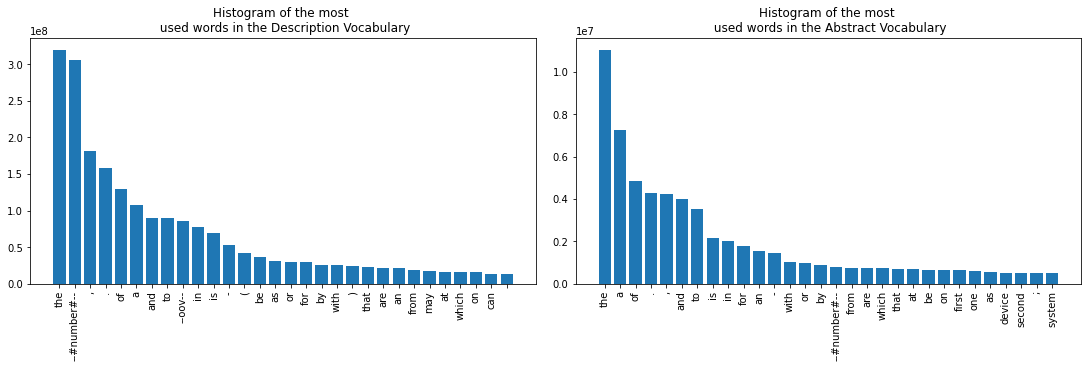

In [ ]:
plt.rcParams['figure.figsize'] = [15,5]
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_vocab_hist(desc_vocab, 'Description', axs[0])
plot_vocab_hist(abs_vocab, 'Abstract', axs[1])
plt.show()

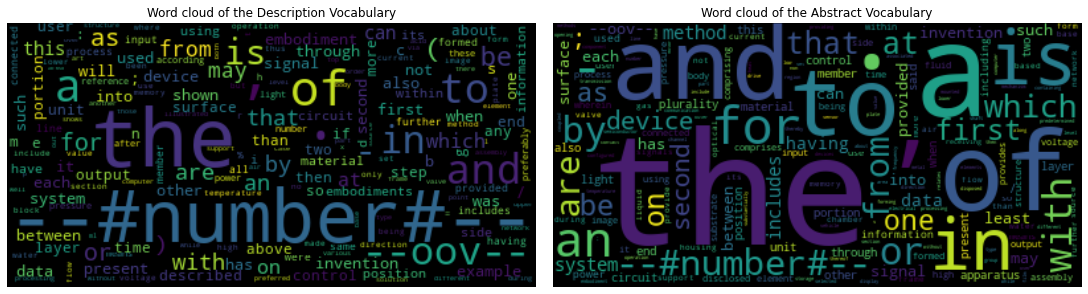

In [ ]:
plt.rcParams['figure.figsize'] = [15,5]
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_vocab_wc(desc_vocab, 'Description', axs[0])
plot_vocab_wc(abs_vocab, 'Abstract', axs[1])
plt.show()

As we can see from the above word clouds, stop words are dominating the corpus. They are skewing the word cloud. 

To build a good text summarization model, we want the model to learn and generate coherent sentences, for which stop words are important. So we will not remove them.  

However, to better understand the distribution of different words in our data, we will remove them for our below analysis.

In [ ]:
import nltk
import string
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('english')
custom_stop_words = ['--oov--', '--#number#--'] + list(string.punctuation)
stop_words = stop_words_nltk + custom_stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stop_words(vocab_counter_df, stop_words=stop_words):
    #remove stop words from the vocab (more efficient when they are sorted (O(N) vs O(N^2) time complexity))
    stop_words = sorted(stop_words)
    temp_df = vocab_counter_df.sort_values(by='Words', ascending=True)
    sorted_vocab = [[w,c] for w,c in zip(temp_df.Words.to_list(), temp_df.Counts.to_list())]

    a, b = len(sorted_vocab), len(stop_words)
    i=j=0
    counter = 0
    while i<a and j<b:
        if stop_words[j] == sorted_vocab[i][0]:
            sorted_vocab[i][1] = 'remove'
            counter += 1
            j += 1
        elif stop_words[j] < sorted_vocab[i][0]:
            j += 1
        elif stop_words[j] > sorted_vocab[i][0]:
            i += 1
        else:
            print('some bug')
            break
    sorted_vocab_ex_stop_words = dict(sorted([(k,v) for k,v in sorted_vocab if v != 'remove'], key=lambda x: x[1], reverse=True))
    return vocab_counter_to_df(sorted_vocab_ex_stop_words)

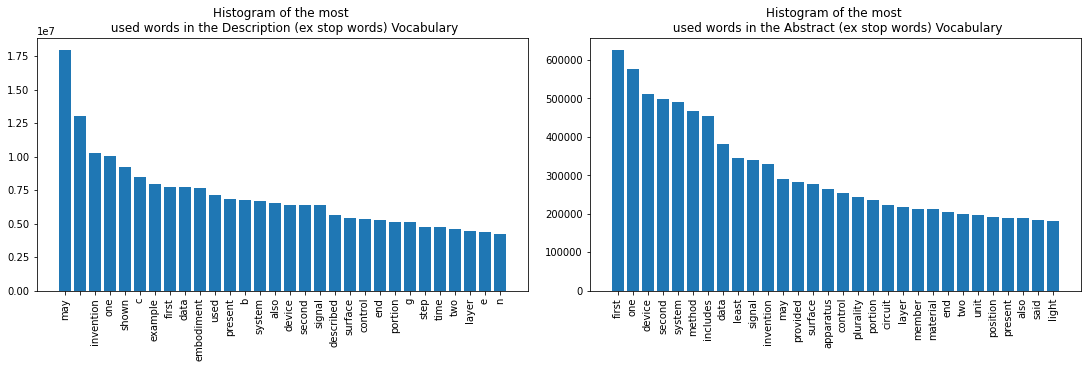

In [ ]:
plt.rcParams['figure.figsize'] = [15,5]
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_vocab_hist(remove_stop_words(desc_vocab), 'Description (ex stop words)', axs[0], s=0, n=30)
plot_vocab_hist(remove_stop_words(abs_vocab), 'Abstract (ex stop words)', axs[1], s=0, n=30)
plt.show()

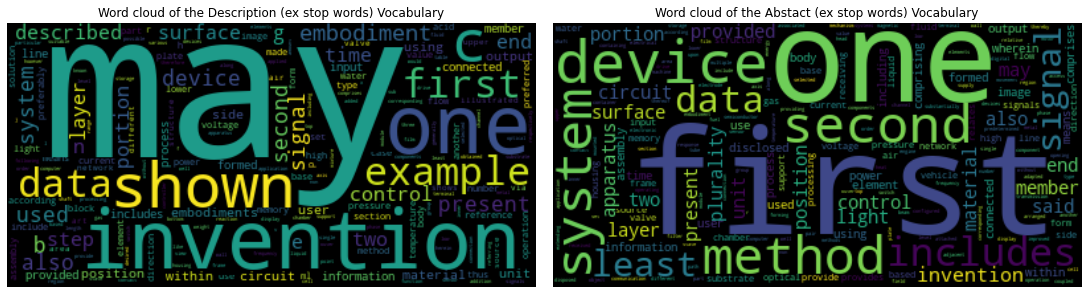

In [ ]:
plt.rcParams['figure.figsize'] = [15,5]
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_vocab_wc(remove_stop_words(desc_vocab), 'Description (ex stop words)', axs[0])
plot_vocab_wc(remove_stop_words(abs_vocab), 'Abstact (ex stop words)', axs[1])
plt.show()

Now we can see words that we'd expect to see in a patent e.g. invention, embodiment, present, circuit, etc

### Distribution of the Description and Abstract Lengths for Different cpc Codes

In [ ]:
def process_text_abstract_dist_parallel_results(result):
    text_len = [r[0] for r in result]
    abs_len = [r[1] for r in result]
    return text_len, abs_len


def text_abstract_dist_helper(df):
    temp_ds = df.description.apply(Text_PreProcessing)
    text_len = temp_ds.apply(lambda text: len(text))
    temp_ds = df.abstract.apply(Text_PreProcessing)
    abs_len = temp_ds.apply(lambda text: len(text))
    return text_len, abs_len


def text_abstract_dist(cpc_codes, split_types=['train'], prl=True):
    '''
    cpc_codes: string
    split_type: list
    '''

    input_path = './bigPatentData'
    text_length_dict = {}
    abs_length_dict = {}
    for cpc_code in cpc_codes:
        num_examples = 0
        text_length_dict[cpc_code] = pd.DataFrame([])
        abs_length_dict[cpc_code] = pd.DataFrame([])
        print(f'CPC Code: {cpc_code}')
        for split_type in split_types:
            stype_num_examples = 0
            for df in readData_into_PandasDF(input_path,split_type,cpc_code):
                strt = time.time()
                if prl: text_len, abs_len = process_text_abstract_dist_parallel_results(content_reader_parallel(df, text_abstract_dist_helper))
                else: 
                    text_len, abs_len = content_reader_sequential(df, text_abstract_dist_helper)
                    text_len, abs_len = [text_len], [abs_len]
                #update summary variables
                stype_num_examples += len(df) #each row is one example
                num_examples += len(df) #each row is one example
                text_length_dict[cpc_code] = pd.concat([text_length_dict[cpc_code], *text_len])
                abs_length_dict[cpc_code] = pd.concat([abs_length_dict[cpc_code], *abs_len])
                # print(f'\t\tDF Size: {df.shape} and Time Taken: {(time.time()-strt):.1f} seconds')
            print(f'\tFor split type {split_type}: total num examples is {stype_num_examples}')
        print(f"For CPC code {cpc_code}: total num of examples is {num_examples}")
        print(f'Description length mean is {text_length_dict[cpc_code].mean().values[0]:.0f}, max is {text_length_dict[cpc_code].max().values[0]:.0f}, and the quantile dist. is as follows:')
        print(text_length_dict[cpc_code].quantile([0.1,0.25,0.5,0.75,0.9,0.95], axis=0).T)
        print(f'Abstract length mean is {abs_length_dict[cpc_code].mean().values[0]:.0f}, max is {abs_length_dict[cpc_code].max().values[0]:.0f}, and the quantile dist. is as follows:')
        print(abs_length_dict[cpc_code].quantile([0.1,0.25,0.5,0.75,0.9,0.95], axis=0).T)
        print('*'*50, '\n')
    return text_length_dict, abs_length_dict

distributions = text_abstract_dist(cpc_codes='abcdefghy', split_types=['train', 'val', 'test'], prl=True)

CPC Code: a
	For split type train: total num examples is 174134
	For split type val: total num examples is 9674
	For split type test: total num examples is 9675
For CPC code a: total num of examples is 193483
Description length mean is 3515, max is 107628, and the quantile dist. is as follows:
     0.10    0.25    0.50    0.75    0.90    0.95
0  1242.0  1754.0  2608.0  4125.0  6596.0  8885.0
Abstract length mean is 109, max is 829, and the quantile dist. is as follows:
   0.10  0.25   0.50   0.75   0.90   0.95
0  49.0  72.0  104.0  142.0  171.0  197.0
************************************************** 

CPC Code: b
	For split type train: total num examples is 161520
	For split type val: total num examples is 8973
	For split type test: total num examples is 8974
For CPC code b: total num of examples is 179467
Description length mean is 2897, max is 60965, and the quantile dist. is as follows:
     0.10    0.25    0.50    0.75    0.90    0.95
0  1219.0  1656.0  2340.0  3425.0  5050.0  65

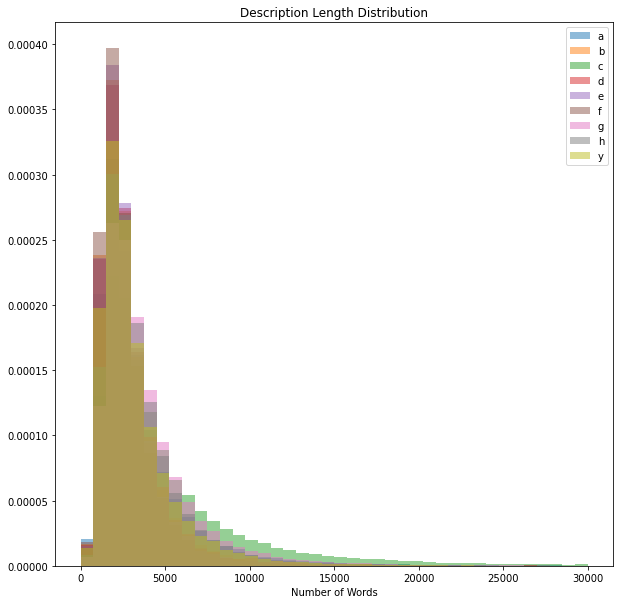

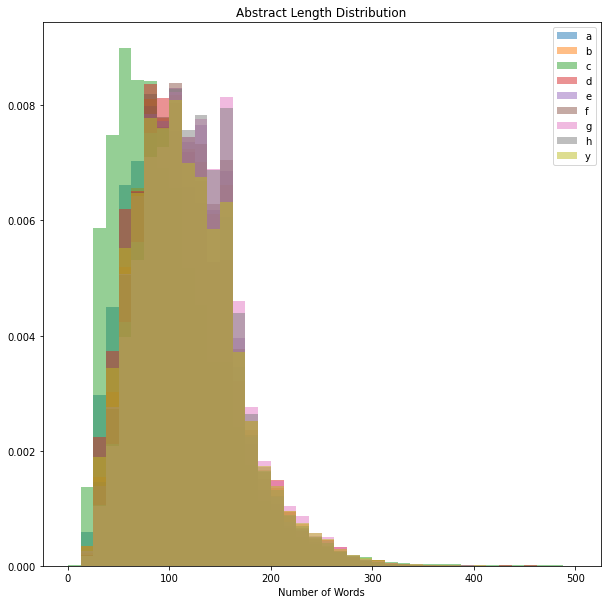

In [ ]:
import numpy as np
plt.rcParams['figure.figsize'] = [10,10]
def plot_multiple_hists(dist, title, range):
    for k,d in dist.items():
        plt.hist(d.values, bins=40, alpha=0.5, label=k, density=True, range=range)
    plt.legend(loc='upper right')
    plt.title(f'{title} Length Distribution')
    plt.xlabel('Number of Words')
    plt.show()

# test = {1: np.random.rand(100000,1)}
plot_multiple_hists(distributions[0], 'Description', range=(0,30000))
plot_multiple_hists(distributions[1], 'Abstract', range=(0,500))

While the maximum length across all the datasets is over 140k, most of the data has much shorter length. Thus, we can take advantage of this. In particular, to minimize computational challenges involved in training models with long sequences of inputs, we will limit the dataset to those with text length of below 4000 and abstract length of below 150. 

### Topic Modelling


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
#This is TBD

## Save Word2IDX and IDX2Word Dictionaries as well as Vocabulary 
(after removing words that appear less than 10 times in the corpus)

In [ ]:
desc_vocab_file_name = "desc_vocab_de_after_preprocess_text.json"
desc_vocab = load_vocab(desc_vocab_file_name)
print(f'The size of the description vocabulary is {len(desc_vocab)}')

abs_vocab_file_name = "abs_vocab_de_after_preprocess_text.json"
abs_vocab = load_vocab(abs_vocab_file_name)
print(f'The size of the abstract vocabulary is {len(abs_vocab)}')

desc_vocab = vocab_counter_to_df(desc_vocab)
desc_vocab['word2idx'] = range(1,len(desc_vocab)+1)
print(f'Desc\n: {desc_vocab.head(), desc_vocab.shape}')

abs_vocab = vocab_counter_to_df(abs_vocab)
abs_vocab['word2idx'] = range(1,len(abs_vocab)+1)
print(f'Abs\n: {abs_vocab.head(), abs_vocab.shape}')

The size of the description vocabulary is 126271
The size of the abstract vocabulary is 28817
Desc
: (     Words   Counts  word2idx
1  firstly     1478         1
2        ,  4820259         2
3       it   363892         3
4   should    59454         4
5       be  1197940         5, (126271, 3))
Abs
: (       Words  Counts  word2idx
1        the  441736         1
2  invention    9745         2
3    relates    3100         3
4         to  136801         4
5          a  270778         5, (28817, 3))


In [ ]:
def modify_token_idx(vocab_counter_df, tokens, idxs):
    def set_word2idx(vocab_counter_df, token, new_w2idx):
        temp_idx = vocab_counter_df[vocab_counter_df.Words == token].word2idx.values[0]
        print(f'\tNeed to swap {token} with: {vocab_counter_df.loc[vocab_counter_df.word2idx == new_w2idx,:].Words.values}')
        vocab_counter_df.loc[vocab_counter_df.word2idx == new_w2idx, 'word2idx'] = temp_idx
        vocab_counter_df.loc[vocab_counter_df.Words == token, 'word2idx'] = new_w2idx
        return vocab_counter_df
    
    def add_token(vocab_counter_df, tokens, idxs):
        for token in tokens:
            vocab_counter_df = vocab_counter_df.append({'Words':token, 'Counts': 999999, \
                                                        'word2idx':len(vocab_counter_df)+1}, ignore_index=True)
        return vocab_counter_df
    vocab_counter_df = add_token(vocab_counter_df, tokens, idxs)

    tokens = tokens + ['--oov--', '--#number#--']
    idxs = idxs + [1,2] #make '--oov--' have word2idx=1 and --#number#-- have word2idx=2
    for token,idx in zip(tokens, idxs):
        vocab_counter_df = set_word2idx(vocab_counter_df, token, idx)
    vocab_counter_df.sort_values(by='word2idx', inplace=True)
    return vocab_counter_df

print('Description')
desc_vocab = modify_token_idx(desc_vocab, tokens=['--null--'], idxs=[0])
print(desc_vocab.head(6), desc_vocab.shape)
print('\nAbstract')
abs_vocab = modify_token_idx(abs_vocab, tokens=['--null--', '--start--', '--stop--'], idxs=[0,3,4])
print(abs_vocab.head(6), abs_vocab.shape)


Description
	Need to swap --null-- with: []
	Need to swap --oov-- with: ['firstly']
	Need to swap --#number#-- with: [',']
               Words   Counts  word2idx
126271      --null--   999999         0
47           --oov--  1456640         1
87      --#number#--  9578221         2
2                 it   363892         3
3             should    59454         4
4                 be  1197940         5 (126272, 3)

Abstract
	Need to swap --null-- with: []
	Need to swap --start-- with: ['relates']
	Need to swap --stop-- with: ['to']
	Need to swap --oov-- with: ['the']
	Need to swap --#number#-- with: ['invention']
              Words  Counts  word2idx
28817      --null--  999999         0
479         --oov--    3923         1
477    --#number#--   12912         2
28818     --start--  999999         3
28819      --stop--  999999         4
4                 a  270778         5 (28820, 3)


In [ ]:
#only keep the words that appear at least 10 times in the corpus
def remove_low_count_words(vocab_counter_df, n=10):
    vocab_counter_df = vocab_counter_df[vocab_counter_df.Counts>=n]
    vocab_counter_df = vocab_counter_df.sort_values(by='word2idx') #this is redundant
    return vocab_counter_df

desc_vocab = remove_low_count_words(desc_vocab)
print(f'Description {desc_vocab.shape}')
abs_vocab = remove_low_count_words(abs_vocab)
print(f'Abstract {abs_vocab.shape}')

Description (36828, 3)
Abstract (10769, 3)


In [ ]:
def save_vocab(vocab_counter_df, vocab_file_name):
    #save vocabulary as json file after removing infrequently used words
    vocab_counter = {word: count for word,count in zip(vocab_counter_df.Words.to_list(), vocab_counter_df.Counts)}
    print(len(vocab_counter))
    with open(vocab_file_name, "w") as fh:
        json.dump(vocab_counter, fh)

save_vocab(desc_vocab, vocab_file_name = "desc_vocab_final_de_after_preprocess_text.json")
save_vocab(abs_vocab, vocab_file_name = "abs_vocab_final_de_after_preprocess_text.json")

36828
10769


In [ ]:
def save_word2idx(vocab_counter_df, word2idx_file_name):
    #save word2idx as a Python dictionary (for faster lookups)
    word2idx = {word: idx for word,idx in zip(vocab_counter_df.Words.to_list(), vocab_counter_df.word2idx)}
    print(len(word2idx))
    with open(word2idx_file_name, "w") as fh:
        json.dump(word2idx, fh)


save_word2idx(desc_vocab, word2idx_file_name = "desc_de_word2idx.json")
save_word2idx(abs_vocab, word2idx_file_name = "abs_de_word2idx.json")

36828
10769


In [ ]:
def save_idx2word(vocab_counter_df, idx2word_file_name):
    #save idx2word as a Python dictionary (for faster lookups)
    idx2word = {idx: word for word,idx in zip(vocab_counter_df.Words.to_list(), vocab_counter_df.word2idx)}
    print(len(idx2word))
    with open(idx2word_file_name, "w") as fh:
        json.dump(idx2word, fh)

save_idx2word(desc_vocab, idx2word_file_name = "desc_de_idx2word.json")
save_idx2word(abs_vocab, idx2word_file_name = "abs_de_idx2word.json")

36828
10769


## Save the Training, Val, and Test Data as a Numpy Array using Word2idx

In [ ]:
def load_word2idx(file_name):
    with open(file_name, 'r') as fh:
        word2idx = json.load(fh)
    print(len(word2idx))
    return word2idx

desc_word2idx = load_word2idx(file_name = 'desc_de_word2idx.json')
abs_word2idx = load_word2idx(file_name = 'abs_de_word2idx.json')

36828
10769


In [ ]:
import shutil
from itertools import zip_longest

def cpc2idx(cpc_code):
    dct = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'y':8}
    return dct[cpc_code]


def add_strt_stp_tokens(text):
    #for abstract add <--start--> and <--stop--> tokens.
    text = ['--start--'] + text + ['--stop--']
    return text

def create_numpy_array(max_len, word2idx):
    def helper(text):
        np_array = np.zeros([1,max_len], dtype=np.int32)
        for i,w in enumerate(text):
            if w.isnumeric():
                w = '--#number#--'
            elif w not in word2idx:
                w = '--oov--'
            np_array[0,i] = word2idx[w]
        return np_array
    return helper

def create_and_save_preprocessed_data_prl_results(result):
    df = pd.concat([r for r in result], axis=0)
    return df


def create_and_save_preprocessed_data_helper(df):
    max_text_len = 4000
    max_abs_len = 150

    df_temp = df
    text_ds = df.description.apply(Text_PreProcessing)
    text_len = text_ds.apply(lambda text: len(text))
    abs_ds = df.abstract.apply(Text_PreProcessing)
    abs_ds = abs_ds.apply(add_strt_stp_tokens) #add start and stop tokens to the abstract
    abs_len = abs_ds.apply(lambda text: len(text))
    cpc_ds = df.cpc_code

    filter_idx = (text_len < max_text_len) & (abs_len < max_abs_len)
    text_ds = text_ds[filter_idx]
    df = text_ds.to_frame()
    df['abstract'] = abs_ds[filter_idx]
    df['cpc_code'] = cpc_ds[filter_idx]

    #numpy array
    df['np_description'] = df['description'].apply(create_numpy_array(max_text_len, desc_word2idx))
    df['np_abstract'] = df['abstract'].apply(create_numpy_array(max_abs_len, abs_word2idx))
    df['np_cpc_code'] = df['cpc_code'].apply(cpc2idx)

    #keep the original data too
    df['original_description'] = df_temp.description
    df['original_abstract'] = df_temp.abstract

    return df


def save_file(df, file_name_root):
    #shuffle the dataframe
    df = df.sample(frac=1, random_state=1).reset_index(drop=True)
    print(f'\t\tSaving... {file_name_root}: size is {len(df)}')
    file_name = file_name_root + '_str_json.gz'
    df_string = df[['description', 'abstract', 'cpc_code', 
                    'original_description', 'original_abstract']].reset_index(drop=True)
    # print(df_string.head(), df_string.shape, df_string.columns)
    df_string.to_json(file_name, compression='gzip')

    #save data as numpy arrays (description and abstract)
    file_name = file_name_root + '_np.npz'
    df_numpy = df[['np_description', 'np_abstract', 'np_cpc_code']].reset_index(drop=True)
    np_array = df_numpy.to_numpy()
    # print(df_numpy.head(), df_numpy.shape, df_numpy.columns)
    # print(np_array.shape)
    np.savez_compressed(file_name, data=np_array) #col0=description and col1=abstract and col2=cpccode


def create_and_save_preprocessed_data(cpc_codes, split_type='train', prl=True, save=True):
    '''
    This function pre-processes the data using the vocabulary generated from processed text and save it in compressed raw string .json and numpy array .npz format
    cpc_codes<string>: can be abcdefghy    
    split_type<string>: can be train, test, val
    prl<bool>: True
    '''
    input_path = './bigPatentData'
    output_path = './bigPatentPreprocessedData'
    dir_name = os.path.join(output_path,split_type,cpc_codes)
    if os.path.exists(dir_name): shutil.rmtree(dir_name)        
    os.mkdir(dir_name)
    data_gens = []
    num_examples = 0
    max_df_size = 20000
    for cpc_code in cpc_codes:
        data_gens.append(readData_into_PandasDF(input_path,split_type,cpc_code, max_df_size = max_df_size//len(cpc_codes)))
    idx = 0
    df_save = pd.DataFrame([])
    for df_list in zip_longest(*data_gens):
        strt = time.time()
        df = []
        for i, df_temp in enumerate(df_list):
            if df_temp is not None:
                df_temp['cpc_code'] = cpc_codes[i]
                df.append(df_temp)
        print(f'Iteration {idx}')
        df = pd.concat(df)
        #shuffle the dataframe
        df = df.sample(frac=1, random_state=1).reset_index(drop=True)
        # print(df.head(10), df.shape, df.cpc_code[df.cpc_code == 'd'].count(), df.cpc_code[df.cpc_code == 'e'].count())
        if prl: df = create_and_save_preprocessed_data_prl_results(content_reader_parallel(df, create_and_save_preprocessed_data_helper))
        else: df = content_reader_sequential(df, create_and_save_preprocessed_data_helper)
        #update summary variables
        num_examples += len(df) #each line in df is one example
        print(f'\tDF Shape: {df.shape} and Time Taken: {(time.time()-strt):.1f} seconds')
        df_save = pd.concat([df_save, df])
        if len(df_save) > max_df_size:
            if save: save_file(df_save, os.path.join(dir_name, 'data'+str(idx)))
            df_save = pd.DataFrame([])
            idx += 1
    if len(df_save) > 0 and save:
        save_file(df_save, os.path.join(dir_name, 'data'+str(idx)))
    print(f'For {split_type} - {cpc_codes}: the total number of examples are {num_examples}\n')

create_and_save_preprocessed_data(cpc_codes='de', split_type='train', prl=True, save=True)


Iteration 0
	DF Shape: (13942, 8) and Time Taken: 136.2 seconds
Iteration 0
	DF Shape: (7157, 8) and Time Taken: 67.3 seconds
		Saving... ./bigPatentPreprocessedData/train/de/data0: size is 21099
Iteration 1
	DF Shape: (7021, 8) and Time Taken: 73.5 seconds
Iteration 1
	DF Shape: (1198, 8) and Time Taken: 11.6 seconds
		Saving... ./bigPatentPreprocessedData/train/de/data1: size is 8219
For train - de: the total number of examples are 29318



In [ ]:
# Load data (string)
def load_data_string(split_type, cpc_codes, fname=None):
    input_path = './bigPatentPreprocessedData'
    if not fname:
        for file_name in readDataFile(input_path, split_type, cpc_codes):
            if file_name.endswith('.gz'):
                df = pd.read_json(file_name, compression='gzip')
                yield df
    else:
        file_name = os.path.join(input_path,split_type,cpc_codes,fname)
        df = pd.read_json(file_name, compression='gzip')
        yield df



# Load data (numpy array)
def load_data_numpy(split_type, cpc_codes, fname=None):
    input_path = './bigPatentPreprocessedData'
    if not fname:
        for file_name in readDataFile(input_path, split_type, cpc_codes):
            if file_name.endswith('.npz'):
                data_np = np.load(file_name, allow_pickle=True)
                yield data_np
    else:
        file_name = os.path.join(input_path,split_type,cpc_codes,fname)
        data_np = np.load(file_name, allow_pickle=True)
        yield data_np

In [ ]:
data = load_data_string(split_type='train', cpc_codes='de', fname='data0_str_json.gz')
for df in data:
    print(df.head(5), df.shape, df.columns)
    print(df.iloc[0,1])
del data

data = load_data_numpy(split_type='train', cpc_codes='de', fname='data0_np.npz')
for data_np in data:
    print(data_np['data'].shape, data_np['data'][0,0].shape[1], data_np['data'][0,1].shape[1])
    print(data_np['data'][0,1])
del data

                                         description  ...                                  original_abstract
0  [upon, review, of, the, detailed, description,...  ...  a hose puller that includes puller wheels that...
1  [referring, to, the, drawings, for, a, clearer...  ...  an articulated ballast cleaning system utilize...
2  [there, is, represented, in, --oov--, a, porti...  ...  a premium paving unit of elastomeric binder ma...
3  [in, the, drawings, ,, similar, or, correspond...  ...  apparatus for washing and / or dewatering cell...
4  [without, limiting, the, scope, of, the, inven...  ...  a patterned conductive textile is provided by ...

[5 rows x 5 columns] (21099, 5) Index(['description', 'abstract', 'cpc_code', 'original_description',
       'original_abstract'],
      dtype='object')
['--start--', 'a', 'hose', 'puller', 'that', 'includes', 'puller', 'wheels', 'that', 'are', 'motorized', 'and', 'configured', 'to', 'grip', ',', 'among', 'other', 'things', ',', 'a', 'high', '

-------------------------------------------------------------

## Tokenization & RegEx Playground

In [ ]:
import nltk
nltk.download('punkt') #for sent and word tokenizer.
# nltk.download('all', halt_on_error=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Need to do both: word level and character level
#nltk.sent_tokenize #https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb


### Sentence Tokenization

In [ ]:
sent_tokenize = nltk.sent_tokenize
sample_sent = 'We will discuss briefly about the basic syntax, structure and design philosophies. There is a defined hierarchical syntax for Python code which you should remember when writing code! Python is a really powerful programming language!'
sent_tokenize(sample_sent)

['We will discuss briefly about the basic syntax, structure and design philosophies.',
 'There is a defined hierarchical syntax for Python code which you should remember when writing code!',
 'Python is a really powerful programming language!']

### Word Tokenization

    Some of the main features of the word tokenizer are:  
        * Splits and separates out periods that appear at the end of a
        sentence
        * Splits and separates commas and single quotes when followed by
        whitespaces
        * Most punctuation characters are split and separated into
        independent tokens
        * Splits words with standard contractions—examples would be
        don’t to do and n’t

In [ ]:
word_tokenize = nltk.word_tokenize
#string.split() vs tokenizer
# sent = "This is a foo, bar sentence. Another sentence in this example."
print(f'string split: {sample_sent.split(" ")}')

print(f'NLTK word tokenizer: {word_tokenize(sample_sent)}')

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
tokenizer = Tokenizer(nlp.vocab)
tokens = tokenizer(sample_sent)
print(f'Spacy word tokenizer 1: {[t.text for t in tokens]}')

import spacy
nlp = spacy.blank("en")
tokens = nlp(sample_sent)
print(f'Spacy word tokenizer 2: {[t.text for t in tokens]}')

string split: ['We', 'will', 'discuss', 'briefly', 'about', 'the', 'basic', 'syntax,', 'structure', 'and', 'design', 'philosophies.', 'There', 'is', 'a', 'defined', 'hierarchical', 'syntax', 'for', 'Python', 'code', 'which', 'you', 'should', 'remember', 'when', 'writing', 'code!', 'Python', 'is', 'a', 'really', 'powerful', 'programming', 'language!']
NLTK word tokenizer: ['We', 'will', 'discuss', 'briefly', 'about', 'the', 'basic', 'syntax', ',', 'structure', 'and', 'design', 'philosophies', '.', 'There', 'is', 'a', 'defined', 'hierarchical', 'syntax', 'for', 'Python', 'code', 'which', 'you', 'should', 'remember', 'when', 'writing', 'code', '!', 'Python', 'is', 'a', 'really', 'powerful', 'programming', 'language', '!']
Spacy word tokenizer 1: ['We', 'will', 'discuss', 'briefly', 'about', 'the', 'basic', 'syntax,', 'structure', 'and', 'design', 'philosophies.', 'There', 'is', 'a', 'defined', 'hierarchical', 'syntax', 'for', 'Python', 'code', 'which', 'you', 'should', 'remember', 'when',

### Regex

In [ ]:
import re
print(re.findall(r'\w+', 'this123%$\wd'))

sample_sent = 'We will discuss briefly about the basic syntax, structure and design philosophies. There is a defined hierarchical syntax for Python code which you should remember when writing code! Python is a really powerful programming language!'
match = 'python'
print(re.findall(match, sample_sent, flags=re.IGNORECASE))

sample_sent = 'There are different versions of Python. Python1 is very old. Then came Python2 and then Python3. Python4 will come in future.'
match = 'python\d+'
print(re.findall(match, sample_sent, flags=re.IGNORECASE))

replace = 'C++'
print(re.sub(match, replace, sample_sent, flags=re.IGNORECASE))

['this123', 'wd']
['Python', 'Python']
['Python1', 'Python2', 'Python3', 'Python4']
There are different versions of Python. C++ is very old. Then came C++ and then C++. C++ will come in future.


In [ ]:
import re
import string
import time

sent = "This is course on Python can can't q . It's a good e . g . of language and is good . i . e . This is F . A . A . O . That is aPython1".lower()
# match = [s for s in string.punctuation]
# re.findall('( ([a-z] \.) ([a-z] \.)* ([a-z] \.))', sent)
# re.findall(' [a-z] \. [a-z] \.', sent)
# re.sub('[a-z]\d', '[a-z]', sent)
# re.sub("can('t)?", 'zzzzzzz', sent)


In [ ]:
sent = "This is course on Python can can't q . It's a good e . g . of language and is good . i . e . This is F . A . A . O . That is aPython1".lower()
re.findall('\'', sent)

["'", "'"]

In [ ]:
sent = "This is course on [ Python ] can can't q . It's a good e . g . of language and is good . i . e . This is F . A . A . O . That is aPython1".lower()
re.sub(r'\[ (\w+) \]', r'\1', sent)

"this is course on python can can't q . it's a good e . g . of language and is good . i . e . this is f . a . a . o . that is apython1"

In [ ]:
sent = "This is course on [ Python ]. can can't q . It's a good e . g . of language and is good . i . e . This is F . A . A . O . That is aPython1".lower()
re.sub(r'([\.\,])?([\]\)])([\.\,])', r'\1 \2 \3', sent)

"this is course on [ python  ] . can can't q . it's a good e . g . of language and is good . i . e . this is f . a . a . o . that is apython1"

In [ ]:
re.sub(r'\[(\d+)\]', r'\1', '[52] apples and [31] mangoes')

'52 apples and 31 mangoes'

In [ ]:
text_list = sent.split(' ')

' '.join(get_abbreviations(text_list))

"this is course on python can can't q . it's a good e.g. UNK UNK UNK of language and is good . i.e. UNK UNK UNK this is f.a.a.o. UNK UNK UNK UNK UNK UNK UNK that is apython1"

In [ ]:
#to get rid of very long underscores
replacement_string = 'UNK'
sent = "Figure 1 is wh2______________________________________regional it is . And the other is test__________________________________country ."
sent = sent.encode('unicode-escape').decode() #convert to raw string
myRegEx1 = re.compile(r'\S*_(_)+_\S*')
print(myRegEx1.sub(replacement_string, sent))

#to get rid of unicode characters
sent = "This is a bad character -(\u2212 and so have \xb0- to remove it . Another is (\u2212)-[[ that too goes . One more \u03bcm18 ."
sent = sent.encode('unicode-escape').decode() #convert to raw string
myRegEx2 = re.compile(r'\S*\\[a-z]\w+\S*')
print(myRegEx2.sub(replacement_string, sent))

#to get rid of numbers (do this after removing unicodes)
sent = "This is a number 123 , 0123, abc123 character -(\u2212 and so have \xb0- to remove it . Another is (\u2212)-[[ that too goes . One more \u03bcm18 ."
sent = sent.encode('unicode-escape').decode() #convert to raw string
# myRegEx3 = re.compile(r'((\d+[a-z]+)|([a-z]+\d+)|([a-z]+\d+[a-z]+))')
myRegEx3 = re.compile(r'\s+\d+\s+')
print(myRegEx3.sub(' #number# ', sent))

sent = 'This is a sentence ## &# & . '
sent = sent.encode('unicode-escape').decode() #convert to raw string
myRegEx4 = re.compile(r'[&,;:\\/?!+=-^%$#]{2,}')
print(myRegEx4.sub(' #number# ', sent))


Figure 1 is UNK it is . And the other is UNK .
This is a bad character UNK and so have UNK to remove it . Another is UNK that too goes . One more UNK .
This is a number #number# , 0123, abc123 character -(\u2212 and so have \xb0- to remove it . Another is (\u2212)-[[ that too goes . One more \u03bcm18 .
This is a sentence  #number#   #number#  & . 


In [ ]:
myRegex = re.compile('python')
myRegex.findall(sent)
# myRegex.sub('3', sent)
# mo = myRegex.search(sent)
# print(mo.group())

['python', 'python']

## Data Collection Playground

In [ ]:
!cp Data_Collection_Script.py /content/

In [ ]:
os.chdir('/content')
!ls ./bigPatentData/

readData.py  readMe.txt  test  test.tar.gz  train.tar.gz  val.tar.gz


In [ ]:
# !tar xzf ./bigPatentData/test.tar.gz -C ./bigPatentData
!gzip -dr ./bigPatentData/test

In [ ]:
!ls

Data_Collection_Script.py  gdrive  sample_data


In [ ]:
!rm -rf bigPatentData

In [ ]:
!python Data_Collection_Script.py


Geting BigPatent Data...
Done Unzipping
Done Unzipping all the files inside the main data folder
The BigPatent dataset has 1207222 training examples and is 26204.7MB in size.
The BigPatent dataset md5 checksum (for *.tar.gz) is: 1f1c264c29e80c111b3a6a28e81cabbc

Geting Arxiv Data...
Running Unzip...
Done Unzipping
The Arxiv dataset has 203037 training examples and is 15150.2MB in size.
The Arxiv dataset md5 checksum (for *.zip) is: 6242aaf5cfcc7814473eee8b779c1b9f

Geting Arxiv Pubmed...
Running Unzip...
Done Unzipping
The Pubmed dataset has 119924 training examples and is 4940.0MB in size.
The Pubmed dataset md5 checksum (for *.zip) is: 3ae396f2b690253e7379a038b410300c

Geting CNN Data...
Done Unzipping
The CNN dataset has 92579 examples and is 392.4MB in size.
The CNN dataset md5 checksum (for *.tgz) is: 85ac23a1926a831e8f46a6b8eaf57263

Geting Daily Mail Data...
Done Unzipping
The Daily Mail dataset has 219506 examples and is 979.2MB in size.
The Daily Mail dataset md5 checksum (for

In [ ]:
data

1207222

In [ ]:
!ls

bigPatentData  Data_Collection_Script.py  gdrive  sample_data


In [ ]:
import os
def find_num_examples_in_dir(path_dir):
    totsize= 0
    for dirpath, dirnames, filenames in os.walk(path_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            totsize += find_num_examples(fp)
    return totsize



def find_num_examples(file_name):
    with open(file_name) as f:
        num_examples = 0
        for l in f:
            num_examples += 1
    return num_examples
data = find_num_examples_in_dir('./bigPatentData/train')


In [ ]:
# !ls /content/val/a
!cp /content/bigPatentData/readMe.txt readMe.txt 

In [ ]:
!ls

bigPatentData  Data_Collection_Script.py  gdrive  sample_data


In [ ]:
!tar xzf ./big_patent_data.tar.gz


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [ ]:
!ls


big_patent_data.tar.gz	Data_Collection_Script.py  gdrive  sample_data


In [ ]:
!os.chdir('sample_data')

/bin/bash: -c: line 0: syntax error near unexpected token `'sample_data''
/bin/bash: -c: line 0: `os.chdir('sample_data')'


In [ ]:
!ls -alh

total 32K
drwxr-xr-x 1 root root 4.0K Jan 21 04:09 .
drwxr-xr-x 1 root root 4.0K Jan 21 03:54 ..
-rw-r--r-- 1 root root  141 Jan 21 04:09 big_patent_data.tar.gz
drwxr-xr-x 1 root root 4.0K Jan 15 17:28 .config
-rw------- 1 root root 7.3K Jan 21 02:16 Data_Collection_Script.py
drwx------ 5 root root 4.0K Jan 21 03:59 gdrive
drwxr-xr-x 1 root root 4.0K Jan 15 17:28 sample_data
